**This code developed a one-step DenseNet Model that was built to predict severity score from CXR images.**

Reference:
1. Pytorch tutorials: Finetuning Torchvision Models: Nathan Inkawhich <https://github.com/inkawhich>__

2. @article{Cohen2020Severity,
title = {Predicting COVID-19 Pneumonia Severity on Chest X-ray with Deep Learning},
author = {Cohen, Joseph Paul and Dao, Lan and Morrison, Paul and Roth, Karsten and Bengio, Yoshua and Shen, Beiyi and Abbasi, Almas and Hoshmand-Kochi, Mahsa and Ghassemi, Marzyeh and Li, Haifang and Duong, Tim Q},
journal = {Cureus Medical Journal},
doi = {10.7759/cureus.9448}
url = {https://www.cureus.com/articles/35692-predicting-covid-19-pneumonia-severity-on-chest-x-ray-with-deep-learning},
year = {2020}
}
github:https://github.com/mlmed/covid-severity


In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, models
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import time
import copy
from sklearn.metrics import r2_score
import sklearn, sklearn.manifold
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
# Define Our Dataset (image, label)
class SeverityDataset(Dataset):
    """Covid Severity dataset. """

    def __init__(self, data, root_dir, geographic_mean = True):
        """
        Args:
            data : label data
            root_dir (string): Directory with all the images.
        """
        self.label_frame = data
        self.root_dir = root_dir
        self.transform = transform
        self.geographic_mean = geographic_mean
        
    def __len__(self):
        return len(self.label_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # open image
        img_name = os.path.join(self.root_dir,self.label_frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        preprocess = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        image = preprocess(image)

        # Label
        #[idx, 1]: geographic score     [idx, 2]: opacity score
        if self.geographic_mean == True:
          n = 1
        else:
          n = 2
        label = self.label_frame.iloc[idx, n]
        label = np.array([label])
        label = label.astype('float')    

        return image, label, img_name

In [ ]:
def train_val_dataset(dataset, val_split=0.2, random_state=11):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=random_state)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
# Read severity score.csv
label_path='/content/drive/MyDrive/11522 Capstone project personal /paper2 code & data/covid-severity-scores-new.csv'
severity_data = pd.read_csv(label_path,skiprows=5)

# Load Dataset: geographic_mean  opacity (image, label)
image_root='/content/drive/MyDrive/11522 Capstone project personal /paper2 code & data/images'
train_geographic_mean = SeverityDataset(severity_data,root_dir=image_root, geographic_mean=True)
train_opacity = SeverityDataset(severity_data,root_dir=image_root, geographic_mean=False)

#### Set parameters
val_split = 0.2  # Split train val 80%:20%
random_state = 10

num_workers=20
batch_size=20

##----------------------------------------------------------------------------------------------
# geographic
dataset_geographic_mean = train_val_dataset(train_geographic_mean, val_split=val_split,random_state=random_state)
print(len(dataset_geographic_mean['train']))
print(len(dataset_geographic_mean['val']))
# Opacity
dataset_opacity = train_val_dataset(train_opacity,val_split=val_split,random_state=random_state)
print(len(dataset_opacity['train']))
print(len(dataset_opacity['val']))

# Dataloader
dataloaders_geographic = {x:DataLoader(dataset_geographic_mean[x],batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train','val']}
dataloaders_opacity = {x:DataLoader(dataset_opacity[x],batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train','val']}

74
19
74
19


In [ ]:
#### Model
model_name = "densenet"
num_classes = 1 #
num_epochs = 300
feature_extract = False  # Flag for feature extracting. When False, we finetune the whole model
                         # when True we only update the reshaped layer params

In [ ]:
#train_opacity[1]

In [ ]:
#for image, label in train_dataloader:
#    print(image.size())
#    print(label.size())
#    break

In [ ]:
def train_model(model, dataloaders, criterion, criterion2, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 40

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_mae =0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, img_name in dataloaders[phase]:
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                         
                        #outputs, aux_outputs = model(inputs)
                        #outputs = model(inputs)
                        #aux1, aux2, outputs = model(inputs)
                        #loss1 = criterion(outputs, labels)
                        #loss2 = criterion(aux_outputs, labels)
                        #loss = loss1 + 0.4*loss2
                        outputs = model(inputs)
                        loss = criterion(outputs, labels) #MSE
                        loss_mae = criterion2(outputs, labels) #MAE

                        r2 = r2_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) # R2 scoe
                        
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)#MSE
                        loss_mae = criterion2(outputs, labels) #MAE
                        r2 = r2_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) # R2
                    _, preds = torch.max(outputs, 1)
                         
                        

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # MSE
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                #epoch_loss = loss

                # MAE
                running_mae +=loss_mae.item()* inputs.size(0)
                epoch_mae = running_mae / len(dataloaders[phase].dataset)
                epoch_r2 = r2

            #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
              train_loss_history.append(epoch_loss)


            print('{} Loss MSE: {:.4f} MAE: {:.4f} R2:{:.2%} '.format(phase, epoch_loss, epoch_mae,r2))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Epoch: {}  Best val Loss: {:4f}'.format(best_epoch,best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_loss_history,train_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=False)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.0001, momentum=0.9)
scratch_criterion = nn.MSELoss()#MSE
scratch_criterion2 = nn.L1Loss() #MAE

Epoch 0/299
----------
train Loss MSE: 15.3484 MAE: 3.2140 R2:-174.17% 
val Loss MSE: 19.4793 MAE: 3.6942 R2:-219.56% 

Epoch 1/299
----------
train Loss MSE: 9.9439 MAE: 2.4743 R2:-127.40% 
val Loss MSE: 14.6886 MAE: 3.1725 R2:-140.97% 

Epoch 2/299
----------
train Loss MSE: 6.4573 MAE: 2.0035 R2:-13.62% 
val Loss MSE: 10.0095 MAE: 2.5597 R2:-64.21% 

Epoch 3/299
----------
train Loss MSE: 5.5928 MAE: 2.0385 R2:-2.29% 
val Loss MSE: 7.1284 MAE: 2.1199 R2:-16.94% 

Epoch 4/299
----------
train Loss MSE: 5.8967 MAE: 2.0819 R2:-109.18% 
val Loss MSE: 5.7678 MAE: 2.0069 R2:5.38% 

Epoch 5/299
----------
train Loss MSE: 5.1458 MAE: 1.9425 R2:16.91% 
val Loss MSE: 5.4205 MAE: 1.9605 R2:11.08% 

Epoch 6/299
----------
train Loss MSE: 4.2663 MAE: 1.7776 R2:8.39% 
val Loss MSE: 5.4794 MAE: 1.9502 R2:10.11% 

Epoch 7/299
----------
train Loss MSE: 3.7175 MAE: 1.6359 R2:0.76% 
val Loss MSE: 5.6986 MAE: 1.9498 R2:6.51% 

Epoch 8/299
----------
train Loss MSE: 3.7069 MAE: 1.6076 R2:35.14% 
val Lo

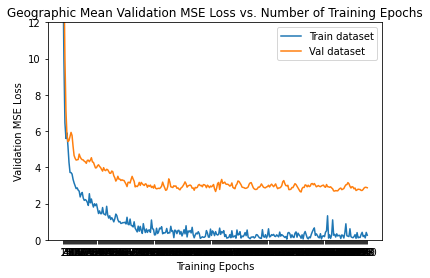

In [ ]:
## Geographic Mean
geo_model,scratch_hist,train_loss = train_model(scratch_model, dataloaders_geographic, scratch_criterion, scratch_criterion2, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="densenet"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# Train and evaluate

ohist = []
shist = []

#ohist = [h.cpu().detach().numpy() for h in train_loss]
ohist = [ h for h in train_loss]


shist = [h for h in scratch_hist]

plt.title("Geographic Mean Validation MSE Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation MSE Loss")
plt.plot(range(1,num_epochs+1),ohist,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist,label="Val dataset")
plt.ylim((0,12.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

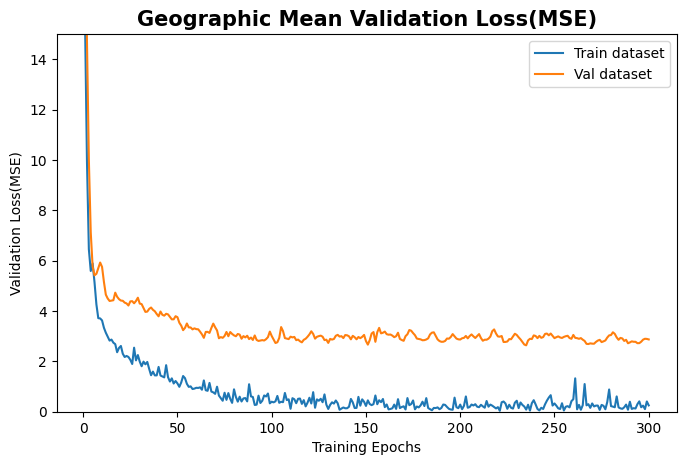

In [ ]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# Train and evaluate

ohist = []
shist = []

#ohist = [h.cpu().detach().numpy() for h in train_loss]
ohist = [ h for h in train_loss]


shist = [h for h in scratch_hist]
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.title("Geographic Mean Validation Loss(MSE)",fontsize=15,fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss(MSE)")
plt.plot(range(1,num_epochs+1),ohist,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist,label="Val dataset")
plt.ylim((0,15.))
plt.xticks(np.arange(0, num_epochs+1, 50.0))
plt.legend()
plt.show()

In [ ]:

def predict_model(model, dataloaders, plot=True):
  predictions = []
  img_label = []

  with torch.no_grad():
    for inputs, labels, img_name in dataloaders['val']:
      labels = labels.float()
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      
      outputs = outputs.cpu().detach().numpy()
      labels = labels.cpu().detach().numpy()
      


      predictions.append(outputs)
      img_label.append(labels)
      return predictions, img_label, img_name




In [ ]:

def showplot(preds, labels, title):


 fig, ax = plt.subplots(figsize=(6,4), dpi=100)
 for x,y,yp in zip(labels,labels,preds):
   plt.plot((x,x),(y,yp),color='red',linestyle="--")


 pmax = int(np.max([preds.max(), labels.max()]))+2
 plt.plot(range(pmax),range(pmax), c="gray", linestyle="--")
 plt.xlim(0,pmax-1)
 plt.ylim(0,pmax-1)
 
 plt.scatter(labels, preds);
 plt.ylabel("Model prediction ($y_{pred}$)")
 plt.xlabel("Ground Truth ($y_{true}$)")
 plt.title(title);
 return

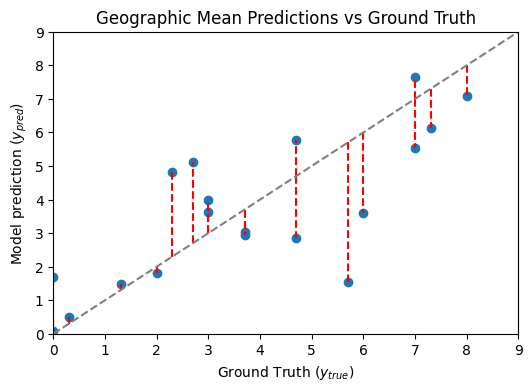

In [ ]:
## Predict Geographic mean
preds_geo, labels_geo, img_name = predict_model(geo_model, dataloaders_geographic)
preds_geo = np.array(preds_geo).reshape(19,1)
labels_geo = np.array(labels_geo).reshape(19,1)
#plot
showplot(preds_geo, labels_geo,"Geographic Mean Predictions vs Ground Truth")


In [ ]:
a=0
print('predict:{} label:{}'.format(preds_geo[a],labels_geo[a] ))
len(preds_geo)

predict:[3.0192454] label:[3.7]


19

In [ ]:
for i in range(len(preds_geo)):
  print('[{}]. predict:{} label:{}  diff:{}'.format(i,preds_geo[i],labels_geo[i], preds_geo[i]-labels_geo[i] ))

[0]. predict:[3.0192454] label:[3.7]  diff:[-0.68075466]
[1]. predict:[1.4761364] label:[1.3]  diff:[0.1761365]
[2]. predict:[3.6198354] label:[3.]  diff:[0.6198354]
[3]. predict:[7.0807786] label:[8.]  diff:[-0.9192214]
[4]. predict:[5.5446296] label:[7.]  diff:[-1.4553704]
[5]. predict:[3.9847944] label:[3.]  diff:[0.9847944]
[6]. predict:[4.825456] label:[2.3]  diff:[2.5254562]
[7]. predict:[1.5321499] label:[5.7]  diff:[-4.16785]
[8]. predict:[0.0826336] label:[0.]  diff:[0.0826336]
[9]. predict:[6.134336] label:[7.3]  diff:[-1.1656642]
[10]. predict:[3.6063263] label:[6.]  diff:[-2.3936737]
[11]. predict:[2.8541596] label:[4.7]  diff:[-1.8458402]
[12]. predict:[2.9414978] label:[3.7]  diff:[-0.75850224]
[13]. predict:[1.7040918] label:[0.]  diff:[1.7040918]
[14]. predict:[7.6631746] label:[7.]  diff:[0.6631746]
[15]. predict:[5.125945] label:[2.7]  diff:[2.425945]
[16]. predict:[5.7879453] label:[4.7]  diff:[1.0879455]
[17]. predict:[1.7964588] label:[2.]  diff:[-0.20354116]
[18].

In [ ]:
labels_geo[]

array([1.3], dtype=float32)

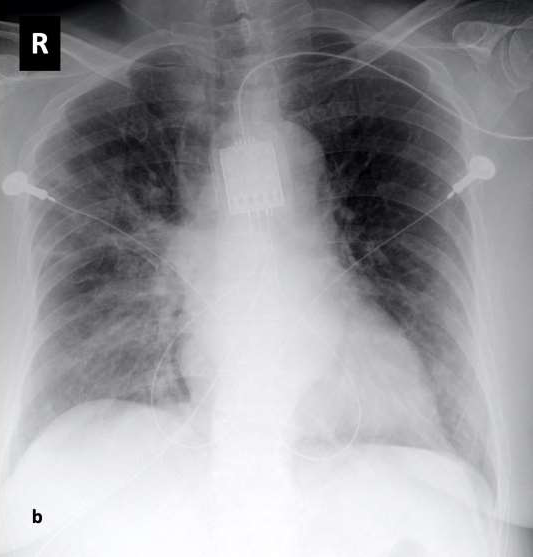

In [ ]:
Image.open(img_name[11]).convert("RGB")

Epoch 0/299
----------
train Loss MSE: 1.7759 MAE: 0.9539 R2:60.78% 
val Loss MSE: 2.8705 MAE: 1.2652 R2:-25.01% 

Epoch 1/299
----------
train Loss MSE: 0.8419 MAE: 0.6318 R2:93.21% 
val Loss MSE: 2.9923 MAE: 1.4182 R2:-30.32% 

Epoch 2/299
----------
train Loss MSE: 0.3268 MAE: 0.4692 R2:82.47% 
val Loss MSE: 1.8507 MAE: 1.0114 R2:19.40% 

Epoch 3/299
----------
train Loss MSE: 0.4734 MAE: 0.5545 R2:87.99% 
val Loss MSE: 1.4758 MAE: 0.9194 R2:35.73% 

Epoch 4/299
----------
train Loss MSE: 0.5225 MAE: 0.5633 R2:52.59% 
val Loss MSE: 1.4575 MAE: 0.9656 R2:36.52% 

Epoch 5/299
----------
train Loss MSE: 0.3004 MAE: 0.4407 R2:94.67% 
val Loss MSE: 1.5016 MAE: 0.9223 R2:34.60% 

Epoch 6/299
----------
train Loss MSE: 0.3735 MAE: 0.4904 R2:79.16% 
val Loss MSE: 1.6924 MAE: 0.9646 R2:26.30% 

Epoch 7/299
----------
train Loss MSE: 0.4002 MAE: 0.4798 R2:44.29% 
val Loss MSE: 1.7120 MAE: 1.0028 R2:25.44% 

Epoch 8/299
----------
train Loss MSE: 0.3066 MAE: 0.4560 R2:89.10% 
val Loss MSE: 1.7

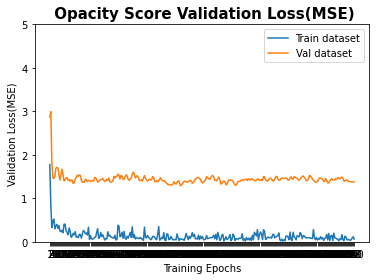

In [ ]:
## Opacity Score 
num_epochs_opacity = 300
opa_model,scratch_hist2,train_loss2 = train_model(scratch_model, dataloaders_opacity, scratch_criterion, scratch_criterion2, scratch_optimizer, num_epochs=num_epochs_opacity, is_inception=(model_name=="densenet"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# Train and evaluate

ohist2 = []
shist2 = []

#ohist = [h.cpu().detach().numpy() for h in train_loss]
ohist2 = [ h for h in train_loss2]
shist2 = [h for h in scratch_hist2]

plt.title(" Opacity Score Validation Loss(MSE)",fontsize=15,fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss(MSE)")
plt.plot(range(1,num_epochs+1),ohist2,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist2,label="Val dataset")
plt.ylim((0,5.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

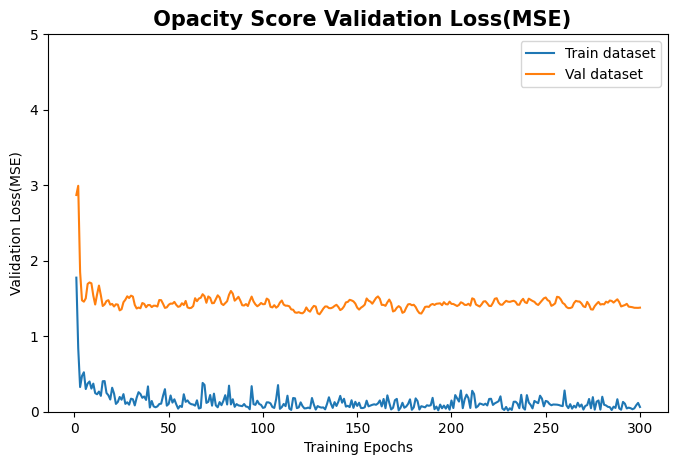

In [ ]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# Train and evaluate

ohist2 = []
shist2 = []

#ohist = [h.cpu().detach().numpy() for h in train_loss]
ohist2 = [ h for h in train_loss2]


shist2 = [h for h in scratch_hist2]
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
plt.title(" Opacity Score Validation Loss(MSE)",fontsize=15,fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss(MSE)")
plt.plot(range(1,num_epochs+1),ohist2,label="Train dataset")
plt.plot(range(1,num_epochs+1),shist2,label="Val dataset")
plt.ylim((0,5.))
plt.xticks(np.arange(0, num_epochs+1, 50.0))
plt.legend()
plt.show()

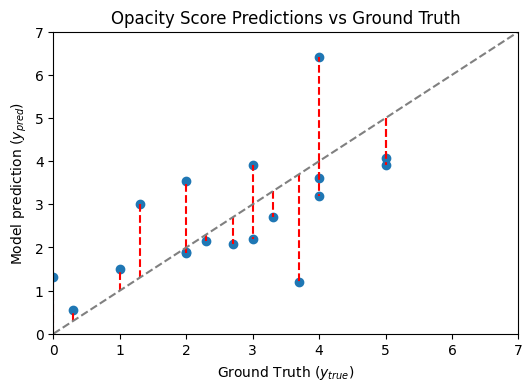

In [ ]:
## Predict Opacity Score
preds_opa, labels_opa, img_name2 = predict_model(opa_model, dataloaders_opacity)
preds_opa = np.array(preds_opa).reshape(19,1)
labels_opa = np.array(labels_opa).reshape(19,1)
#plot
showplot(preds_opa, labels_opa,"Opacity Score Predictions vs Ground Truth")

In [ ]:
for i in range(len(preds_opa)):
  print('[{}]. predict:{} label:{}  diff:{}'.format(i,preds_opa[i],labels_opa[i], preds_opa[i]-labels_opa[i] ))

[0]. predict:[2.1926537] label:[3.]  diff:[-0.80734634]
[1]. predict:[1.5052484] label:[1.]  diff:[0.5052484]
[2]. predict:[1.8928268] label:[2.]  diff:[-0.1071732]
[3]. predict:[3.5433972] label:[2.]  diff:[1.5433972]
[4]. predict:[6.41704] label:[4.]  diff:[2.4170399]
[5]. predict:[4.073869] label:[5.]  diff:[-0.9261308]
[6]. predict:[2.157223] label:[2.3]  diff:[-0.14277697]
[7]. predict:[3.9141636] label:[5.]  diff:[-1.0858364]
[8]. predict:[0.5481553] label:[0.3]  diff:[0.2481553]
[9]. predict:[2.7115316] label:[3.3]  diff:[-0.5884683]
[10]. predict:[3.2030714] label:[4.]  diff:[-0.79692864]
[11]. predict:[3.9050863] label:[3.]  diff:[0.9050863]
[12]. predict:[1.3144933] label:[0.]  diff:[1.3144933]
[13]. predict:[1.8758672] label:[2.]  diff:[-0.12413275]
[14]. predict:[1.198854] label:[3.7]  diff:[-2.501146]
[15]. predict:[3.616779] label:[4.]  diff:[-0.3832209]
[16]. predict:[3.0039475] label:[1.3]  diff:[1.7039475]
[17]. predict:[-0.13273863] label:[0.]  diff:[-0.13273863]
[18]

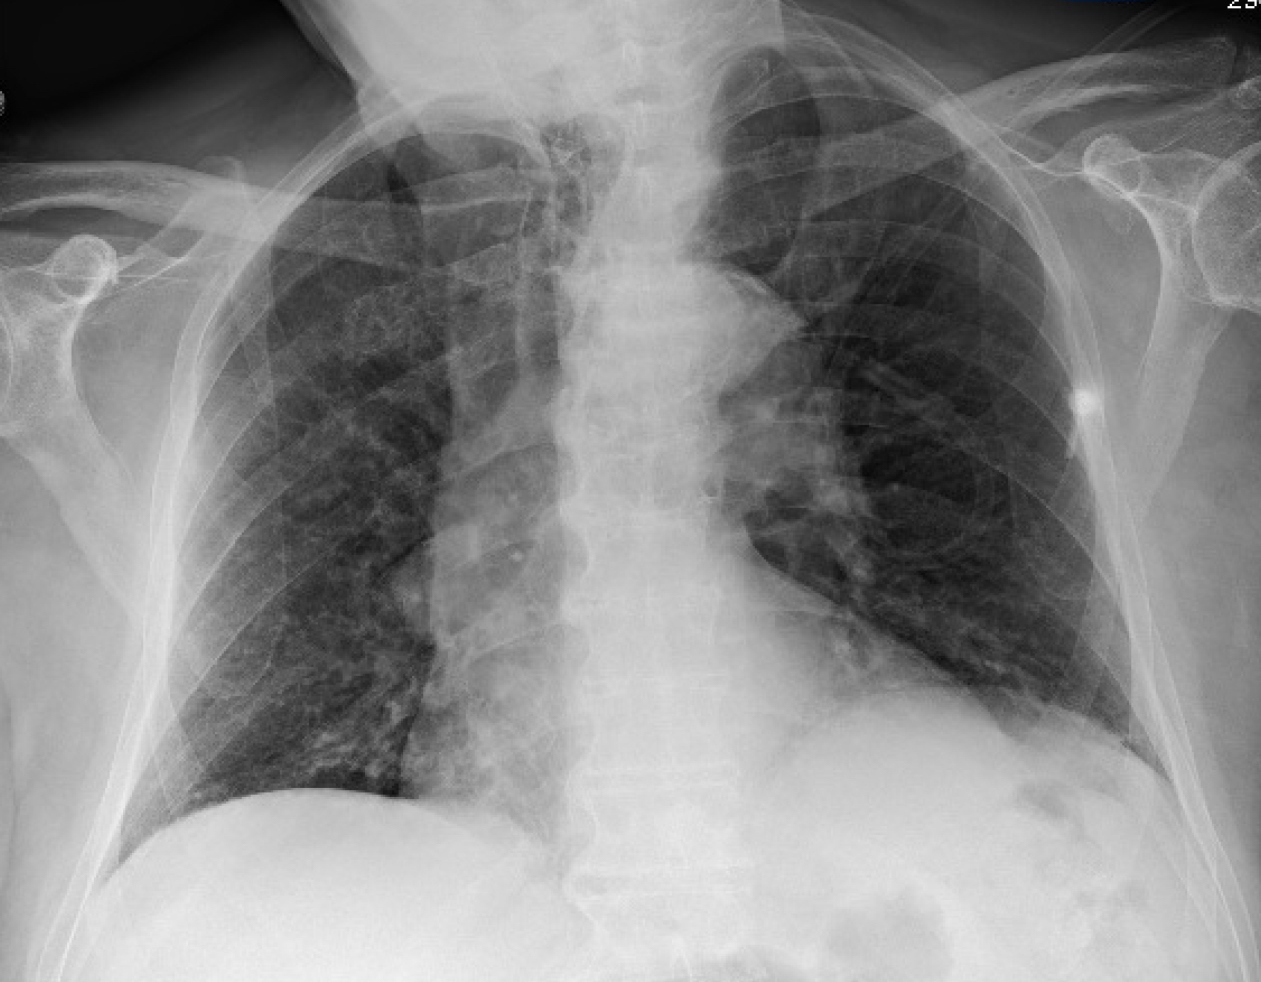

In [ ]:
Image.open(img_name2[12]).convert("RGB")